In [63]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sympy as sp
import control as ctl
from time import time, sleep

# ANÁLISE NO DOMÍNIO DA FREQUÊNCIA

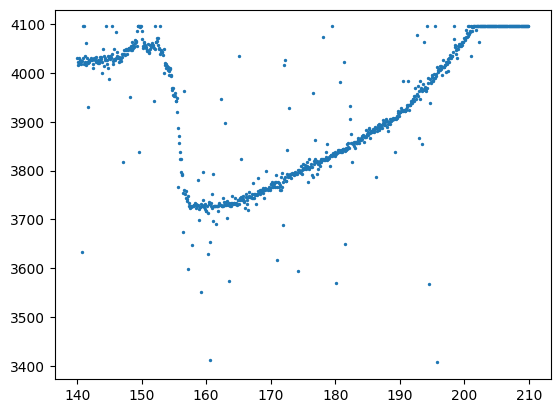

In [64]:
df = pd.read_csv('Files/DataBase.csv')
df = df.loc[(df['Hora'] > 140) & (df['Hora'] < 210)]

xData = df['Hora'].to_numpy()
yData = df['Analogico'].to_numpy()

plt.scatter(xData, yData, s=2)

(0.0, 10000.0)

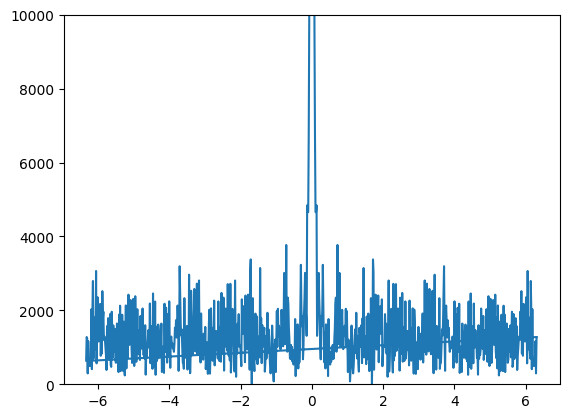

In [65]:
yFourier = np.fft.fft(yData)
xFourier = np.fft.fftfreq(len(yData), xData[1] - xData[0])

plt.plot(xFourier, np.abs(yFourier))
plt.ylim(0, 10000)

(0.0, 10000.0)

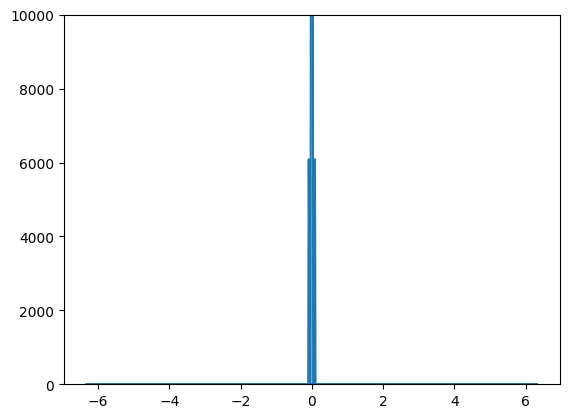

In [66]:
def passaBaixa(frequencyArray, magnitudeArray, upperLimit):
    allowed = np.abs(frequencyArray) <= upperLimit
    magnitudeArray[~allowed] = 0
    return magnitudeArray

yFiltrado = passaBaixa(xFourier, yFourier, 0.1) # ELIMINANDO TODAS AS FREQUÊNCIAS ACIMA DE 1 HZ

plt.plot(xFourier, yFiltrado.real)
plt.ylim(0, 10000)

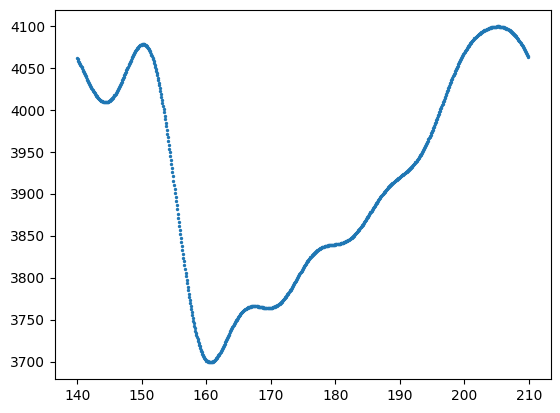

In [67]:
yData = np.fft.ifft(yFiltrado)
plt.scatter(xData, yData.real, s=2)

# CONFERINDO
- Desejado: A(0.1 Hz) = 0

In [68]:
def getOmega(f):
    return 2*np.pi*f

omega_desired = getOmega(0.1)
omega_desired

0.6283185307179586

In [69]:
s = ctl.TransferFunction.s
C = 1/(10*s + 1)

C

TransferFunction(array([1]), array([10,  1]))

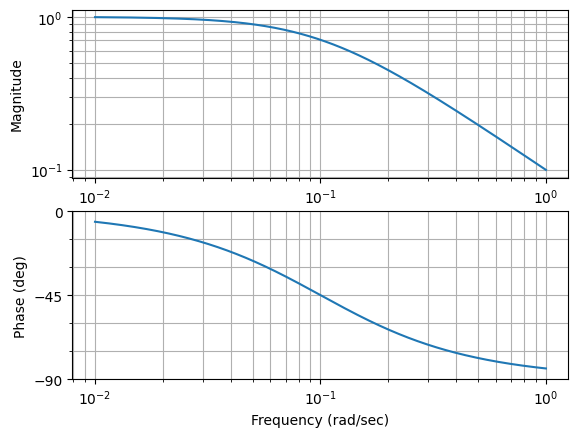

In [70]:
mag, fase, omega = ctl.bode(C, plot=True)

In [71]:
df = pd.DataFrame({'mag': mag, 'fase': fase, 'omega': omega})
df

,mag,fase,omega
0,0.995037,-0.099669,0.010000
1,0.994992,-0.100126,0.010046
2,0.994946,-0.100586,0.010093
3,0.994899,-0.101047,0.010139
4,0.994852,-0.101511,0.010186
...,...,...,...
995,0.101337,-1.469285,0.981730
996,0.100875,-1.469749,0.986266
997,0.100416,-1.470211,0.990823
998,0.099959,-1.470670,0.995401


In [72]:
df['difference'] = abs(df['omega'] - omega_desired)
df.loc[df['difference'] == df['difference'].min()]

,mag,fase,omega,difference
898,0.157312,-1.412829,0.627766,0.000553


# CONTROLE DIGITAL MALHA ABERTA

![WhatsApp Image 2024-01-25 at 21.44.56.jpeg](<attachment:WhatsApp Image 2024-01-25 at 21.44.56.jpeg>)
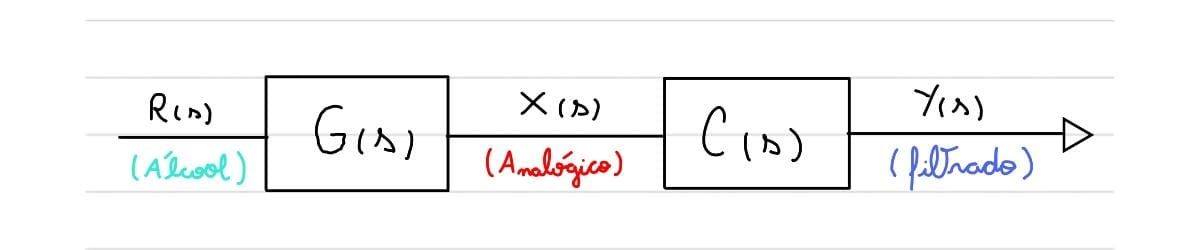

In [73]:
s, z = sp.symbols('s z')
T = 0.5
ordem = 1

C = 1/(10*s + 1)
C

1/(10*s + 1)

- O controlador é passado para o domínio discreto $z$ quando $s \to \frac{2}{T} \cdot \frac{z-1}{z+1}$

In [74]:
tustin = 2/T*(z-1)/(z+1)

C = C.subs(s, tustin).expand().simplify()
C

(z + 1)/(41.0*z - 39.0)

In [75]:
X, Y = sp.symbols('X Y')
sp.Eq(Y/X, C)

Eq(Y/X, (z + 1)/(41.0*z - 39.0))

In [76]:
num, den = sp.fraction(C)

num = (X * num/z**ordem).expand()
den = (Y * den/z**ordem).expand()

eq = sp.Eq(den - num, 0)
eq

Eq(-X - X/z + 41.0*Y - 39.0*Y/z, 0)

In [77]:
eq = eq.subs(X/z**3, sp.symbols('X_{n-3}'))
eq = eq.subs(X/z**2, sp.symbols('X_{n-2}'))
eq = eq.subs(X/z,    sp.symbols('X_{n-1}'))

eq = eq.subs(Y/z**3, sp.symbols('Y_{n-3}'))
eq = eq.subs(Y/z**2, sp.symbols('Y_{n-2}'))
eq = eq.subs(Y/z,    sp.symbols('Y_{n-1}'))

eq

Eq(-X - X_{n-1} + 41.0*Y - 39.0*Y_{n-1}, 0)

In [78]:
ladoDireito = sp.solve(eq, Y)[0]

y = sp.Eq(Y, ladoDireito)
display(y)
print(y)

Eq(Y, 0.024390243902439*X + 0.024390243902439*X_{n-1} + 0.951219512195122*Y_{n-1})

Eq(Y, 0.024390243902439*X + 0.024390243902439*X_{n-1} + 0.951219512195122*Y_{n-1})


In [79]:
x_n  = 0
x_n1 = 0
y_n  = 0
y_n1 = 0 

def controlador(input):
    global x_n, x_n1, y_n, y_n1
    output = 0.024390243902439*input + 0.024390243902439*x_n1 + 0.951219512195122*y_n1
    
    x_n1 = x_n
    y_n1 = y_n

    x_n  = input
    y_n  = output

    return output


In [94]:
df = pd.read_csv('Files/DataBase.csv')
df = df.loc[(df['Hora'] > 130) & (df['Hora'] < 230)]
xData = df['Hora'].to_numpy()
yData = df['Analogico'].to_numpy()

n = 1
outputData = [0 for i in range(n)]

In [95]:
while n < len(yData):
    input   = yData[n]
    output  = controlador(input)
    outputData.append(output)
    n += 1

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


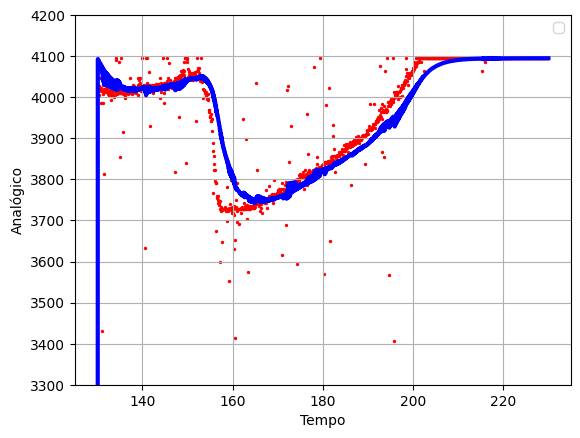

In [105]:
plt.scatter(xData, yData, s=2, color='red')
plt.plot(xData, outputData, linewidth=3, color='blue')

plt.ylim(3300, 4200)
plt.xlabel('Tempo')
plt.ylabel('Analógico')
plt.legend()
plt.grid()
plt.show()